## Distribution Transfer using CycleGAN

The aim of this notebook is to map samples from a normal distribution N(µ1,σ1) to samples from another normal distribution N(µ2,σ2) using CycleGAN. This task could be done easily by direct computation and we will in fact use this to verify our networks.

We will generate two unpaired datasets constituted of samples from the normal distributions N(µ1,σ1) and N(µ2,σ2), with which we will train our CycleGAN to have a second mapping.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

np.random.seed(42)

### Dataset of unpaired gaussian distributions

In [2]:
class Unpaired_Gaussian_Dataset(data.Dataset):
    '''Generate a dataset of samples from a Gaussian N(µ1,σ1) 
       and another dataset from a Gaussian N(µ2,σ2)'''
    
    def __init__(self, mu1, sigma1, mu2, sigma2, size):
        """
        Construct the datasets based on the parameters of the gaussians
        
        Parameters:
            mu1    -- mean of the first gaussian
            sigma1 -- standard deviation of the first gaussian
            mu2    -- mean of the second gaussian
            sigma2 -- standard deviation of the second gaussian
            size   -- size of the dataset
        """
        self.mu1 = mu1
        self.mu2 = mu2
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        
        # Generate samples from N(µ1,σ1) and compute their label - their pair in N(µ2,σ2)
        
        self.x = np.random.normal(mu1, sigma1, size)[:, np.newaxis]
        self.y = np.random.normal(mu2, sigma2, size)[:, np.newaxis]
        
    def __len__(self):
        'Denotes the total number of samples'
        return self.x.shape[0]

    def __getitem__(self, index):
        '''
        Get one sample of data
        
        Parameter :
            index -- index of the sample in the dataset
            
        Return the sample in the first gaussian (x) and in the second gaussian (y)
        '''
        x = torch.from_numpy(self.x[index]).float()
        y = torch.from_numpy(self.y[index]).float()

        return x, y

In [3]:
# Definition of the parameters

mu1, sigma1 = 0, 1   # For N(µ1,σ1)
mu2, sigma2 = 10, 3   # For N(µ2,σ2)

train_size, test_size = 700, 300

params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 2}

# Instantiation of the train and test dataset

ds_train = Unpaired_Gaussian_Dataset(mu1, sigma1, mu2, sigma2, train_size)
dl_train = data.DataLoader(ds_train, **params)

ds_test = Unpaired_Gaussian_Dataset(mu1, sigma1, mu2, sigma2, test_size)
dl_test = data.DataLoader(ds_test, **params)

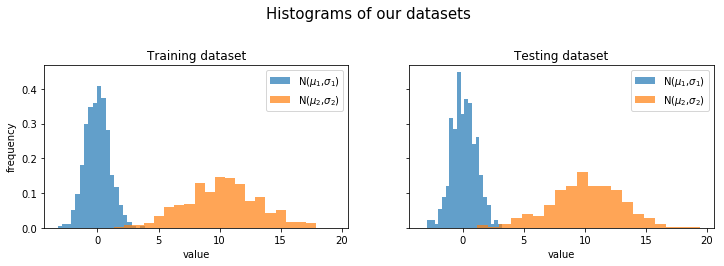

In [4]:
# Visualisation of our data

fig, ax = plt.subplots(1, 2, figsize=(12,3), sharex=True, sharey=True)

ax[0].hist(ds_train.x, bins=20, label=r'N($\mu_1$,$\sigma_1$)', alpha=0.7, density=True)
ax[0].hist(ds_train.y, bins=20, label=r'N($\mu_2$,$\sigma_2$)', alpha=0.7, density=True)
ax[0].set_xlabel('value')
ax[0].set_ylabel('frequency')
ax[0].legend(loc='best')
ax[0].set_title('Training dataset')

ax[1].hist(ds_test.x, bins=20, label=r'N($\mu_1$,$\sigma_1$)', alpha=0.7, density=True)
ax[1].hist(ds_test.y, bins=20, label=r'N($\mu_2$,$\sigma_2$)', alpha=0.7, density=True)
ax[1].set_xlabel('value')
ax[1].legend(loc='best')
ax[1].set_title('Testing dataset')

fig.suptitle("Histograms of our datasets", y=1.15, fontsize=15)
plt.show()

### CycleGAN network

In [5]:
# Definition of a generator
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 1)    
    
    # Generate a scalar which represents the value in the other distribution
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [6]:
# Definition of a discriminator
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 1)    
        
    # Compute a scalar which determines how probable the value belongs to the other distribution
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return (self.fc2(x))

In [7]:
# Definition of the CycleGAN
class CycleGAN(nn.Module):
    """This class implements the CycleGAN model, for learning (gaussian)
       distribution-to-distribution translation without paired data"""
    
    def __init__(self):
        """Initialize the CycleGAN class"""
        super(CycleGAN, self).__init__()
        
        # Instantiate Generators
        self.netG_X = Generator()
        self.netG_Y = Generator()
        # Instantiate Discriminators
        self.netD_X = Discriminator()
        self.netD_Y = Discriminator()
        
        # Define loss functions
        self.criterionGAN = nn.BCEWithLogitsLoss()
        self.criterionCycle = nn.MSELoss()
        
        # Define parameters which control the relative importance of the two objectives (cycle loss vs. GAN loss)
        self.lambda_X = 1/3       # Forward cycle parameter
        self.lambda_Y = 1/30      # Backward cycle parameter
        
        # Define optimizers
        lr_gen = 1e-3
        lr_disc = 1e-2
        self.optimizer_G = torch.optim.SGD(itertools.chain(self.netG_X.parameters(), self.netG_Y.parameters()), lr=lr_gen)
        self.optimizer_D = torch.optim.SGD(itertools.chain(self.netD_X.parameters(), self.netD_Y.parameters()), lr=lr_disc)
        
        
    def forward(self, x, y):
        """
        Run forward pass
        
        Parameters:
            x -- samples from original distribution
            y -- samples from target distribution
        
        Returns a 4-tuple containing (generated_y, reconstructed_x, generated_x, reconstructed_y),
        where generated_y corresponds to G_X(X) and reconstructed_x to G_Y(G_X(X)).
        """
        fake_y = self.netG_X(x)           # G_X(X)          
        rec_x = self.netG_Y(fake_y)  # G_Y(G_X(X))
        fake_x = self.netG_Y(y)           # G_Y(Y)
        rec_y = self.netG_X(fake_x)  # G_X(G_Y(Y))
        
        return fake_y, rec_x, fake_x, rec_y
    
    
    def loss_D(self, real_X, fake_X, real_Y, fake_Y):
        """
        Compute the loss for the discriminators D_X and D_Y

        Parameters:
            real_X -- the real samples of distribution X
            fake_X -- samples generated by generator Y
            real_Y -- the real samples of distribution Y
            fake_Y -- samples generated by generator X
            
        Return a list containing the discriminators loss.
        """
        ### Loss of discriminator X ###
        
         # Loss on the real samples
        loss_D_X_real = self.criterionGAN(self.netD_X(real_X), torch.full(real_X.shape, 1))
        
         # Loss on the samples generated by a generator
        loss_D_X_fake = self.criterionGAN(self.netD_X(fake_X), torch.full(fake_X.shape, 0))
        
         # Combine loss
        loss_D_X = (loss_D_X_real + loss_D_X_fake) * 0.5
        
        ### Loss of discriminator Y ###
        
         # Loss on the real samples
        loss_D_Y_real = self.criterionGAN(self.netD_Y(real_Y), torch.full(real_Y.shape, 1))
        
         # Loss on the samples generated by a generator
        loss_D_Y_fake = self.criterionGAN(self.netD_Y(fake_Y), torch.full(fake_Y.shape, 0))

         # Combine loss
        loss_D_Y = (loss_D_Y_real + loss_D_Y_fake) * 0.5
        
        return [loss_D_X, loss_D_Y]
        
        
    def loss_G(self, real_X, fake_X, rec_X, real_Y, fake_Y, rec_Y):
        """
        Compute the loss for the generetors G_X and G_Y

        Parameters:
            real_X -- the real samples of distribution X
            fake_X -- samples generated by generator Y
            rec_X  -- samples corresponding to G_Y(G_X(X))
            real_Y -- the real samples of distribution Y
            fake_Y -- samples generated by generator X
            rec_Y  -- samples corresponding to G_X(G_Y(Y))
            
        Return a list containing the generators loss [loss_G_X, loss_G_Y, loss_cycle_X, loss_cycle_Y].
        """        
        # GAN loss D_Y(G_X(X))
        loss_G_X = self.criterionGAN(self.netD_Y(fake_Y), torch.full(fake_Y.shape, 1))
      
        # GAN loss D_X(G_Y(Y))
        loss_G_Y = self.criterionGAN(self.netD_X(fake_X), torch.full(fake_X.shape, 1))
        
        # Forward cycle loss || G_Y(G_X(X)) - X||
        loss_cycle_X = self.criterionCycle(rec_X, real_X) * self.lambda_X
        
        # Backward cycle loss || G_X(G_Y(Y)) - Y||
        loss_cycle_Y = self.criterionCycle(rec_Y, real_Y) * self.lambda_Y
        
        return [loss_G_X, loss_G_Y, loss_cycle_X, loss_cycle_Y]

In [8]:
# Instantiation of the model
cycleGAN = CycleGAN()

In [9]:
# Utility method
def sum_list(l):
    """
    Sum the element of a list
    
    Parameters:
        l -- a python list
    
    Return the sum of the element in the list.
    """
    sum = 0.0
    for elem in l:
        sum += elem
    return sum

In [10]:
def process_data(cycleGAN, x, y, train=False):
    """
    Process data in the network and compute the resulting loss (with or without optimizing the parameters).
    
    Parameters:
        cycleGAN -- an instance of a CycleGAN network
        x        -- samples from original distribution
        y        -- samples from target distribution
        train    -- determine if we also train the network
    
    Return a tuple containing a list of the generators loss [loss_G_X, loss_G_Y, loss_cycle_X, loss_cycle_Y], 
    the discriminator X loss & the discriminator Y loss.
    """
    
    # Forward
    fake_y, rec_x, fake_x, rec_y = cycleGAN.forward(x, y)
    
    # Optimize generators
    cycleGAN.optimizer_G.zero_grad()                                 # set G_A and G_B's gradients to zero
    loss_G = cycleGAN.loss_G(x, fake_x, rec_x, y, fake_y, rec_y)     # compute the different losses for G_A and G_B
    if (train):    
        loss_G_sum = sum_list(loss_G)
        loss_G_sum.backward(retain_graph=True)                       # compute gradients for G_A and G_B
        cycleGAN.optimizer_G.step()                                  # update G_A and G_B's weights
    
    # Optimize discriminators
    cycleGAN.optimizer_D.zero_grad()                                 # set D_A and D_B's gradients to zero
    loss_D = cycleGAN.loss_D(x, fake_x, y, fake_y)                   # compute the different losses for D_A and D_B
    if (train): 
        loss_D_sum = sum_list(loss_D)
        loss_D_sum.backward()                                        # compute gradients for D_A and D_B
        cycleGAN.optimizer_D.step()                                  # update D_A and D_B's weights
    
    return loss_G, loss_D[0], loss_D[1]

In [11]:
def train_cycleGAN(cycleGAN, dl_tr, dl_te, epochs):
    """
    Train a cycleGAN
    
    Parameters :
        cycleGAN  -- the cycleGAN model to train
        ds_tr     -- Training dataset
        epochs    -- Number of epochs
        
    Return two lists containing training losses and testing losses, both for generators and discriminators X and Y.
    """
    
    # Arrays to keep track of the train and test losses at each epoch
    genX_loss_tr_values = []
    genY_loss_tr_values = []
    genCycleX_loss_tr_values = []
    genCycleY_loss_tr_values = []
    disX_loss_tr_values = []
    disY_loss_tr_values = []
    
    genX_loss_te_values = []
    genY_loss_te_values = []
    genCycleX_loss_te_values = []
    genCycleY_loss_te_values = []
    disX_loss_te_values = []
    disY_loss_te_values = []
    
    for ep in range(epochs):
        # Training mode
        cycleGAN.train()
        
        # Variables to accumulate the train losses at one epoch
        genX_loss_tr_run = 0
        genY_loss_tr_run = 0
        genCycleX_loss_tr_run = 0
        genCycleY_loss_tr_run = 0
        disX_loss_tr_run = 0
        disY_loss_tr_run = 0
        
        # Loop for each batches
        for it, batch in enumerate(dl_tr):
            
            x, y = batch

            loss_tr_gen, loss_tr_disX, loss_tr_disY = process_data(cycleGAN, x, y, True)
            
            genX_loss_tr_run += loss_tr_gen[0]
            genY_loss_tr_run += loss_tr_gen[1]
            genCycleX_loss_tr_run += loss_tr_gen[2]
            genCycleY_loss_tr_run += loss_tr_gen[3]
            disX_loss_tr_run += loss_tr_disX
            disY_loss_tr_run += loss_tr_disY
            
            # Display training losses at last iteration
            if (it+1 == dl_tr.__len__()):
                print(('Ep {}/{}, it {}/{}: \n' +
                      '\t G_X loss train: {:.2f}, G_Y loss train: {:.2f}, \n' +
                      '\t G_CycleX loss train {:.2f}, G_CycleY loss train {:.2f}, \n' +
                      '\t D_X loss train: {:.2f}, D_Y loss train: {:.2f} \n').
                      format(ep + 1, epochs, it + 1, dl_tr.__len__(), genX_loss_tr_run/(it+1), 
                             genY_loss_tr_run/(it+1), genCycleX_loss_tr_run/(it+1), 
                             genCycleY_loss_tr_run/(it+1), disX_loss_tr_run/(it+1), disY_loss_tr_run/(it+1)))

        # Compute the mean for each loss (training) in this epoch and stock them
        genX_loss_tr = genX_loss_tr_run / dl_tr.__len__()
        genX_loss_tr_values.append(genX_loss_tr)
        
        genY_loss_tr = genY_loss_tr_run / dl_tr.__len__()
        genY_loss_tr_values.append(genY_loss_tr)
        
        genCycleX_loss_tr = genCycleX_loss_tr_run / dl_tr.__len__()
        genCycleX_loss_tr_values.append(genCycleX_loss_tr)
        
        genCycleY_loss_tr = genCycleY_loss_tr_run / dl_tr.__len__()
        genCycleY_loss_tr_values.append(genCycleY_loss_tr)
        
        disX_loss_tr = disX_loss_tr_run / dl_tr.__len__()
        disX_loss_tr_values.append(disX_loss_tr)
        
        disY_loss_tr = disY_loss_tr_run / dl_tr.__len__()
        disY_loss_tr_values.append(disY_loss_tr)

        # Testing mode
        cycleGAN.eval()
        with torch.no_grad():

            # Variable to accumulate the test losses at one epoch
            genX_loss_te_run = 0
            genY_loss_te_run = 0
            genCycleX_loss_te_run = 0
            genCycleY_loss_te_run = 0
            disX_loss_te_run = 0
            disY_loss_te_run = 0

            for it, batch in enumerate(dl_te):
                x, y = batch

                loss_te_gen, loss_te_disX, loss_te_disY = process_data(cycleGAN, x, y, False)

                genX_loss_te_run += loss_te_gen[0]
                genY_loss_te_run += loss_te_gen[1]
                genCycleX_loss_te_run += loss_te_gen[2]
                genCycleY_loss_te_run += loss_te_gen[3]
                disX_loss_te_run += loss_te_disX
                disY_loss_te_run += loss_te_disY 

            # Compute the mean for each loss (testing) in this epoch and stock them
            genX_loss_te = genX_loss_te_run / dl_te.__len__()
            genX_loss_te_values.append(genX_loss_te)

            genY_loss_te = genY_loss_te_run / dl_te.__len__()
            genY_loss_te_values.append(genY_loss_te)

            genCycleX_loss_te = genCycleX_loss_te_run / dl_te.__len__()
            genCycleX_loss_te_values.append(genCycleX_loss_te)

            genCycleY_loss_te = genCycleY_loss_te_run / dl_te.__len__()
            genCycleY_loss_te_values.append(genCycleY_loss_te)

            disX_loss_te = disX_loss_te_run / dl_te.__len__()
            disX_loss_te_values.append(disX_loss_te)

            disY_loss_te = disY_loss_te_run / dl_te.__len__()
            disY_loss_te_values.append(disY_loss_te)    
            
            # Display test losses
            print(('\t G_X loss test: {:.2f}, G_Y loss test: {:.2f}, \n' +
                  '\t G_CycleX loss test {:.2f}, G_CycleY loss test {:.2f}, \n' +
                  '\t D_X loss test: {:.2f}, D_Y loss test: {:.2f} \n').
                  format(genX_loss_te, genY_loss_te, genCycleX_loss_te, 
                          genCycleY_loss_te, disX_loss_te, disY_loss_te))
            
    
    training_losses = (genX_loss_tr_values, genY_loss_tr_values, genCycleX_loss_tr_values, 
                       genCycleY_loss_tr_values, disX_loss_tr_values, disY_loss_tr_values)
    testing_losses = (genX_loss_te_values, genY_loss_te_values, genCycleX_loss_te_values,
                      genCycleY_loss_te_values, disX_loss_te_values, disY_loss_te_values)
    
    return training_losses, testing_losses

In [12]:
epochs = 200
training_losses, testing_losses = train_cycleGAN(cycleGAN, dl_train, dl_test, epochs)

Ep 1/200, it 22/22: 
	 G_X loss train: 0.63, G_Y loss train: 1.16, 
	 G_CycleX loss train 0.38, G_CycleY loss train 3.97, 
	 D_X loss train: 0.66, D_Y loss train: 0.46 

	 G_X loss test: 0.64, G_Y loss test: 0.83, 
	 G_CycleX loss test 0.42, G_CycleY loss test 3.78, 
	 D_X loss test: 0.73, D_Y loss test: 0.40 

Ep 2/200, it 22/22: 
	 G_X loss train: 0.65, G_Y loss train: 0.80, 
	 G_CycleX loss train 0.37, G_CycleY loss train 3.80, 
	 D_X loss train: 0.73, D_Y loss train: 0.39 

	 G_X loss test: 0.67, G_Y loss test: 0.79, 
	 G_CycleX loss test 0.41, G_CycleY loss test 3.70, 
	 D_X loss test: 0.72, D_Y loss test: 0.38 

Ep 3/200, it 22/22: 
	 G_X loss train: 0.69, G_Y loss train: 0.78, 
	 G_CycleX loss train 0.36, G_CycleY loss train 3.73, 
	 D_X loss train: 0.72, D_Y loss train: 0.37 

	 G_X loss test: 0.71, G_Y loss test: 0.77, 
	 G_CycleX loss test 0.41, G_CycleY loss test 3.59, 
	 D_X loss test: 0.71, D_Y loss test: 0.36 

Ep 4/200, it 22/22: 
	 G_X loss train: 0.72, G_Y loss train: 

	 G_X loss test: 1.44, G_Y loss test: 1.14, 
	 G_CycleX loss test 0.30, G_CycleY loss test 1.40, 
	 D_X loss test: 0.49, D_Y loss test: 0.23 

Ep 28/200, it 22/22: 
	 G_X loss train: 1.41, G_Y loss train: 1.15, 
	 G_CycleX loss train 0.27, G_CycleY loss train 1.40, 
	 D_X loss train: 0.51, D_Y loss train: 0.23 

	 G_X loss test: 1.45, G_Y loss test: 1.13, 
	 G_CycleX loss test 0.30, G_CycleY loss test 1.32, 
	 D_X loss test: 0.49, D_Y loss test: 0.24 

Ep 29/200, it 22/22: 
	 G_X loss train: 1.41, G_Y loss train: 1.13, 
	 G_CycleX loss train 0.27, G_CycleY loss train 1.33, 
	 D_X loss train: 0.51, D_Y loss train: 0.24 

	 G_X loss test: 1.47, G_Y loss test: 1.13, 
	 G_CycleX loss test 0.29, G_CycleY loss test 1.22, 
	 D_X loss test: 0.49, D_Y loss test: 0.24 

Ep 30/200, it 22/22: 
	 G_X loss train: 1.42, G_Y loss train: 1.14, 
	 G_CycleX loss train 0.26, G_CycleY loss train 1.25, 
	 D_X loss train: 0.51, D_Y loss train: 0.25 

	 G_X loss test: 1.43, G_Y loss test: 1.09, 
	 G_CycleX lo

Ep 54/200, it 22/22: 
	 G_X loss train: 1.15, G_Y loss train: 0.80, 
	 G_CycleX loss train 0.18, G_CycleY loss train 0.32, 
	 D_X loss train: 0.63, D_Y loss train: 0.54 

	 G_X loss test: 1.27, G_Y loss test: 0.83, 
	 G_CycleX loss test 0.19, G_CycleY loss test 0.28, 
	 D_X loss test: 0.60, D_Y loss test: 0.54 

Ep 55/200, it 22/22: 
	 G_X loss train: 1.14, G_Y loss train: 0.80, 
	 G_CycleX loss train 0.18, G_CycleY loss train 0.30, 
	 D_X loss train: 0.63, D_Y loss train: 0.55 

	 G_X loss test: 1.23, G_Y loss test: 0.80, 
	 G_CycleX loss test 0.18, G_CycleY loss test 0.25, 
	 D_X loss test: 0.61, D_Y loss test: 0.56 

Ep 56/200, it 22/22: 
	 G_X loss train: 1.13, G_Y loss train: 0.79, 
	 G_CycleX loss train 0.17, G_CycleY loss train 0.28, 
	 D_X loss train: 0.63, D_Y loss train: 0.57 

	 G_X loss test: 1.10, G_Y loss test: 0.78, 
	 G_CycleX loss test 0.18, G_CycleY loss test 0.26, 
	 D_X loss test: 0.62, D_Y loss test: 0.56 

Ep 57/200, it 22/22: 
	 G_X loss train: 1.11, G_Y loss tra

	 G_X loss test: 0.83, G_Y loss test: 0.68, 
	 G_CycleX loss test 0.10, G_CycleY loss test 0.07, 
	 D_X loss test: 0.68, D_Y loss test: 0.76 

Ep 81/200, it 22/22: 
	 G_X loss train: 0.86, G_Y loss train: 0.69, 
	 G_CycleX loss train 0.09, G_CycleY loss train 0.07, 
	 D_X loss train: 0.68, D_Y loss train: 0.77 

	 G_X loss test: 0.84, G_Y loss test: 0.67, 
	 G_CycleX loss test 0.10, G_CycleY loss test 0.08, 
	 D_X loss test: 0.69, D_Y loss test: 0.76 

Ep 82/200, it 22/22: 
	 G_X loss train: 0.86, G_Y loss train: 0.69, 
	 G_CycleX loss train 0.09, G_CycleY loss train 0.07, 
	 D_X loss train: 0.68, D_Y loss train: 0.77 

	 G_X loss test: 0.87, G_Y loss test: 0.67, 
	 G_CycleX loss test 0.10, G_CycleY loss test 0.07, 
	 D_X loss test: 0.68, D_Y loss test: 0.77 

Ep 83/200, it 22/22: 
	 G_X loss train: 0.85, G_Y loss train: 0.69, 
	 G_CycleX loss train 0.08, G_CycleY loss train 0.06, 
	 D_X loss train: 0.68, D_Y loss train: 0.77 

	 G_X loss test: 0.89, G_Y loss test: 0.69, 
	 G_CycleX lo

Ep 107/200, it 22/22: 
	 G_X loss train: 0.78, G_Y loss train: 0.71, 
	 G_CycleX loss train 0.03, G_CycleY loss train 0.02, 
	 D_X loss train: 0.67, D_Y loss train: 0.75 

	 G_X loss test: 0.88, G_Y loss test: 0.71, 
	 G_CycleX loss test 0.03, G_CycleY loss test 0.03, 
	 D_X loss test: 0.67, D_Y loss test: 0.75 

Ep 108/200, it 22/22: 
	 G_X loss train: 0.79, G_Y loss train: 0.71, 
	 G_CycleX loss train 0.03, G_CycleY loss train 0.02, 
	 D_X loss train: 0.67, D_Y loss train: 0.75 

	 G_X loss test: 0.82, G_Y loss test: 0.72, 
	 G_CycleX loss test 0.03, G_CycleY loss test 0.03, 
	 D_X loss test: 0.67, D_Y loss test: 0.74 

Ep 109/200, it 22/22: 
	 G_X loss train: 0.79, G_Y loss train: 0.71, 
	 G_CycleX loss train 0.03, G_CycleY loss train 0.02, 
	 D_X loss train: 0.67, D_Y loss train: 0.75 

	 G_X loss test: 0.78, G_Y loss test: 0.72, 
	 G_CycleX loss test 0.03, G_CycleY loss test 0.03, 
	 D_X loss test: 0.67, D_Y loss test: 0.75 

Ep 110/200, it 22/22: 
	 G_X loss train: 0.78, G_Y loss

	 G_X loss test: 0.84, G_Y loss test: 0.74, 
	 G_CycleX loss test 0.02, G_CycleY loss test 0.02, 
	 D_X loss test: 0.68, D_Y loss test: 0.71 

Ep 134/200, it 22/22: 
	 G_X loss train: 0.76, G_Y loss train: 0.73, 
	 G_CycleX loss train 0.02, G_CycleY loss train 0.01, 
	 D_X loss train: 0.68, D_Y loss train: 0.71 

	 G_X loss test: 0.82, G_Y loss test: 0.75, 
	 G_CycleX loss test 0.02, G_CycleY loss test 0.02, 
	 D_X loss test: 0.67, D_Y loss test: 0.71 

Ep 135/200, it 22/22: 
	 G_X loss train: 0.76, G_Y loss train: 0.73, 
	 G_CycleX loss train 0.02, G_CycleY loss train 0.01, 
	 D_X loss train: 0.68, D_Y loss train: 0.71 

	 G_X loss test: 0.75, G_Y loss test: 0.74, 
	 G_CycleX loss test 0.02, G_CycleY loss test 0.02, 
	 D_X loss test: 0.68, D_Y loss test: 0.71 

Ep 136/200, it 22/22: 
	 G_X loss train: 0.76, G_Y loss train: 0.74, 
	 G_CycleX loss train 0.02, G_CycleY loss train 0.01, 
	 D_X loss train: 0.68, D_Y loss train: 0.71 

	 G_X loss test: 0.73, G_Y loss test: 0.74, 
	 G_CycleX

Ep 160/200, it 22/22: 
	 G_X loss train: 0.73, G_Y loss train: 0.73, 
	 G_CycleX loss train 0.02, G_CycleY loss train 0.01, 
	 D_X loss train: 0.69, D_Y loss train: 0.69 

	 G_X loss test: 0.74, G_Y loss test: 0.74, 
	 G_CycleX loss test 0.01, G_CycleY loss test 0.01, 
	 D_X loss test: 0.69, D_Y loss test: 0.69 

Ep 161/200, it 22/22: 
	 G_X loss train: 0.73, G_Y loss train: 0.73, 
	 G_CycleX loss train 0.02, G_CycleY loss train 0.01, 
	 D_X loss train: 0.69, D_Y loss train: 0.69 

	 G_X loss test: 0.72, G_Y loss test: 0.73, 
	 G_CycleX loss test 0.01, G_CycleY loss test 0.02, 
	 D_X loss test: 0.69, D_Y loss test: 0.69 

Ep 162/200, it 22/22: 
	 G_X loss train: 0.72, G_Y loss train: 0.73, 
	 G_CycleX loss train 0.02, G_CycleY loss train 0.01, 
	 D_X loss train: 0.69, D_Y loss train: 0.69 

	 G_X loss test: 0.77, G_Y loss test: 0.74, 
	 G_CycleX loss test 0.01, G_CycleY loss test 0.01, 
	 D_X loss test: 0.69, D_Y loss test: 0.69 

Ep 163/200, it 22/22: 
	 G_X loss train: 0.73, G_Y loss

	 G_X loss test: 0.67, G_Y loss test: 0.72, 
	 G_CycleX loss test 0.01, G_CycleY loss test 0.01, 
	 D_X loss test: 0.70, D_Y loss test: 0.69 

Ep 187/200, it 22/22: 
	 G_X loss train: 0.70, G_Y loss train: 0.72, 
	 G_CycleX loss train 0.01, G_CycleY loss train 0.01, 
	 D_X loss train: 0.70, D_Y loss train: 0.69 

	 G_X loss test: 0.69, G_Y loss test: 0.72, 
	 G_CycleX loss test 0.01, G_CycleY loss test 0.01, 
	 D_X loss test: 0.70, D_Y loss test: 0.69 

Ep 188/200, it 22/22: 
	 G_X loss train: 0.70, G_Y loss train: 0.72, 
	 G_CycleX loss train 0.01, G_CycleY loss train 0.01, 
	 D_X loss train: 0.70, D_Y loss train: 0.69 

	 G_X loss test: 0.66, G_Y loss test: 0.72, 
	 G_CycleX loss test 0.01, G_CycleY loss test 0.01, 
	 D_X loss test: 0.70, D_Y loss test: 0.69 

Ep 189/200, it 22/22: 
	 G_X loss train: 0.70, G_Y loss train: 0.72, 
	 G_CycleX loss train 0.01, G_CycleY loss train 0.01, 
	 D_X loss train: 0.70, D_Y loss train: 0.69 

	 G_X loss test: 0.75, G_Y loss test: 0.72, 
	 G_CycleX

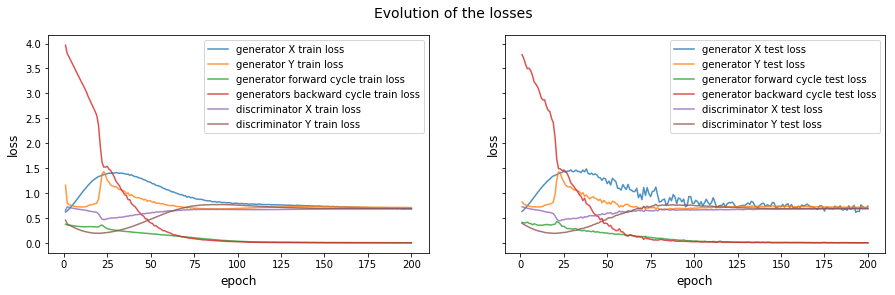

In [13]:
# Visualisation of the evolution of our train losses and test losses

fig, ax = plt.subplots(1, 2, figsize=(15,4), sharex=True, sharey=True)

GX_loss_tr_vs, GY_loss_tr_vs, GCycleX_loss_tr_vs, GCycleY_loss_tr_vs, DX_loss_tr_vs, DY_loss_tr_vs = training_losses

ax[0].plot(np.arange(epochs)+1, GX_loss_tr_vs, label='generator X train loss', alpha=0.8)
ax[0].plot(np.arange(epochs)+1, GY_loss_tr_vs, label='generator Y train loss', alpha=0.8)
ax[0].plot(np.arange(epochs)+1, GCycleX_loss_tr_vs, label='generator forward cycle train loss', alpha=0.8)
ax[0].plot(np.arange(epochs)+1, GCycleY_loss_tr_vs, label='generators backward cycle train loss', alpha=0.8)
ax[0].plot(np.arange(epochs)+1, DX_loss_tr_vs, label='discriminator X train loss', alpha=0.8)
ax[0].plot(np.arange(epochs)+1, DY_loss_tr_vs, label='discriminator Y train loss', alpha=0.8)
ax[0].set_xlabel('epoch', labelpad=5, fontsize='large')
ax[0].set_ylabel('loss', labelpad=5, fontsize='large')
ax[0].legend(loc='best')

GX_loss_te_vs, GY_loss_te_vs, GCycleX_loss_te_vs, GCycleY_loss_te_vs, DX_loss_te_vs, DY_loss_te_vs = testing_losses

ax[1].plot(np.arange(epochs)+1, GX_loss_te_vs, label='generator X test loss', alpha=0.8)
ax[1].plot(np.arange(epochs)+1, GY_loss_te_vs, label='generator Y test loss', alpha=0.8)
ax[1].plot(np.arange(epochs)+1, GCycleX_loss_te_vs, label='generator forward cycle test loss', alpha=0.8)
ax[1].plot(np.arange(epochs)+1, GCycleY_loss_te_vs, label='generator backward cycle test loss', alpha=0.8)
ax[1].plot(np.arange(epochs)+1, DX_loss_te_vs, label='discriminator X test loss', alpha=0.8)
ax[1].plot(np.arange(epochs)+1, DY_loss_te_vs, label='discriminator Y test loss', alpha=0.8)
ax[1].set_xlabel('epoch', labelpad=5, fontsize='large')
ax[1].set_ylabel('loss', labelpad=5, fontsize='large')
ax[1].legend(loc='best')

fig.suptitle('Evolution of the losses', fontsize=14)
plt.show()

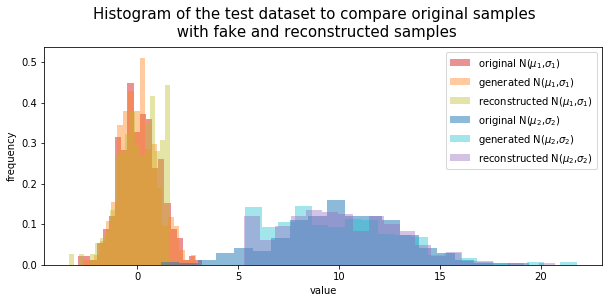

In [14]:
# Get x, fake_x, rec_x, y, fake_y, rec_y from the test set

fake_y = []
rec_y = []
fake_x = []
rec_x = []

for it, batch in enumerate(dl_test):
    x, y = batch
    fake_y_run, rec_x_run, fake_x_run, rec_y_run = cycleGAN(x, y)
    for i in range(fake_y_run.shape[0]):
        fake_y.append(fake_y_run[i].item())
        rec_y.append(rec_y_run[i].item())
        fake_x.append(fake_x_run[i].item())
        rec_x.append(rec_x_run[i].item())

# Visualisation of the output distribution vs. the target distribution of our test dataset        

fig, ax = plt.subplots(figsize=(10,4))

ax.hist(ds_test.x, bins=20, label=r'original N($\mu_1$,$\sigma_1$)', color='tab:red', alpha=0.5, density=True)
ax.hist(fake_x, bins=20, label=r'generated N($\mu_1$,$\sigma_1$)', color='tab:orange', alpha=0.4, density=True)
ax.hist(rec_x, bins=20, label=r'reconstructed N($\mu_1$,$\sigma_1$)', color='tab:olive', alpha=0.4, density=True)
ax.hist(ds_test.y, bins=20, label=r'original N($\mu_2$,$\sigma_2$)', color='tab:blue', alpha=0.5, density=True)
ax.hist(fake_y, bins=20, label=r'generated N($\mu_2$,$\sigma_2$)', color='tab:cyan', alpha=0.4, density=True)
ax.hist(rec_y, bins=20, label=r'reconstructed N($\mu_2$,$\sigma_2$)', color='tab:purple', alpha=0.4, density=True)
ax.set_xlabel('value')
ax.set_ylabel('frequency')
ax.legend(loc='best')

fig.suptitle("Histogram of the test dataset to compare original samples\n with fake and reconstructed samples",
             fontsize=15, y = 1.02)
plt.show()

In [15]:
# Compute the mean and the std of the generated and reconstructed samples

mean_fake_x, std_fake_x = (np.mean(fake_x), np.std(fake_x))
mean_rec_x, std_rec_x = (np.mean(rec_x), np.std(rec_x))

mean_fake_y, std_fake_y = (np.mean(fake_y), np.std(fake_y))
mean_rec_y, std_rec_y = (np.mean(rec_y), np.std(rec_y))

# Compare the parameters of each distribution

moments = ["Mean", "Standard deviation"]

distributionsX = ["Original distribution X", "Generated distribution X", "Reconstructed distribution X"]
dataX = np.array([[mu1, sigma1],
                [mean_fake_x, std_fake_x], 
                [mean_rec_x, std_rec_x]])
dfX = pd.DataFrame(dataX, index=distributionsX, columns=moments)
dfX["Mean"] = dfX['Mean'].map('{:.2f}'.format)
dfX["Standard deviation"] = dfX['Standard deviation'].map('{:.2f}'.format)

distributionsY = ["Original distribution Y", "Generated distribution Y", "Reconstructed distribution Y"]
dataY = np.array([[mu2, sigma2],
                [mean_fake_y, std_fake_y], 
                [mean_rec_y, std_rec_y]])
dfY = pd.DataFrame(dataY, index=distributionsY, columns=moments)
dfY["Mean"] = dfY['Mean'].map('{:.2f}'.format)
dfY["Standard deviation"] = dfY['Standard deviation'].map('{:.2f}'.format)

print(dfX, '\n')
print(dfY)

                              Mean Standard deviation
Original distribution X       0.00               1.00
Generated distribution X      0.07               0.93
Reconstructed distribution X  0.12               1.00 

                               Mean Standard deviation
Original distribution Y       10.00               3.00
Generated distribution Y       9.99               3.18
Reconstructed distribution Y  10.07               2.89
